## Lab 2 - Hopfield Networks

In [151]:
import numpy as np
import random
import matplotlib.pyplot as plt

def generate_memory(height=10, width=10, p=0.5, rng=None):
    # Use the provided RNG or create a new default RNG
    if rng is None:
        rng = np.random.default_rng()
    # Generate activation pattern
    return rng.choice([-1, 1], size=(height * width), p=[1 - p, p])

In [152]:
class HopfieldNetwork:

    def __init__(self, memories, height=10, width=10):
        self.height = height
        self.width = width

        # We set up the weights, with (x*width + y, i*width + j) denoting the weight from (i, j) to (x, y).
        self.set_weights(memories)
        self.activity = np.zeros((height, width))

    def set_weights(self, memories):
        self.W = np.zeros((self.height * self.width, self.height * self.width))
        # Set weights of the network
        for mu in memories:
            self.W += np.outer(mu, mu)

    def compute_input(self):
        return np.dot(self.W, self.activity.flatten())

    def update_activity(self):
        self.activity = np.sign(self.compute_input()).reshape((self.height, self.width))

    def attempt_recall(self, memory, input_pattern, max_iterations=30):
        """
        Clamp the network to the input pattern and let it evolve for a fixed number of iterations.
        Return the Hamming distance between the memory and the final state.
        """
        self.activity = input_pattern
        for _ in range(max_iterations):
            self.update_activity()
            if np.array_equal(self.activity, memory):
                return 0 
        # Return the Hamming distance between the memory and the final state
        return np.sum(self.activity.flatten() != memory)

Hamming distance for memory 1: 0
Hamming distance for memory 2: 0
Hamming distance for memory 3: 0


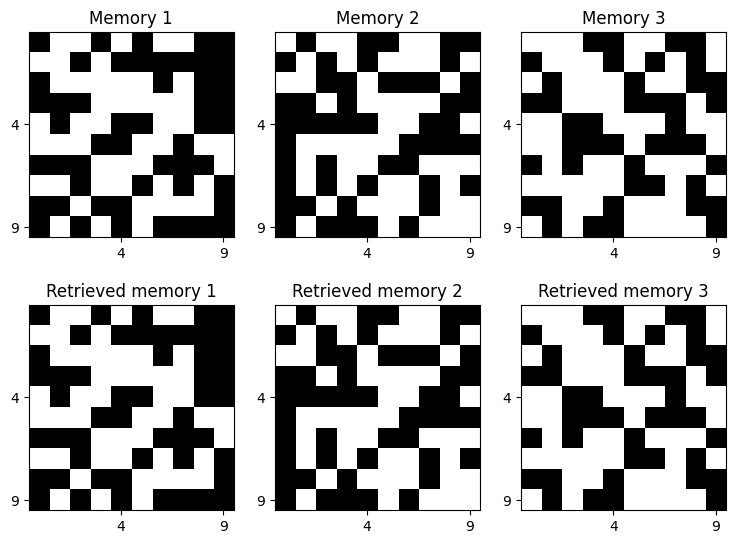

In [153]:
def degrade_input(memory, dropout_p=0.1, rng=None):
    # Use the provided RNG or create a new default RNG
    if rng is None:
        rng = np.random.default_rng()
    # Degrade the input memory
    return np.array([0 if rng.random() < dropout_p else memory[i] for i in range(len(memory))])

mu_1 = generate_memory()
mu_2 = generate_memory()
mu_3 = generate_memory()
memories = [mu_1, mu_2, mu_3]
degraded_memories = [degrade_input(mu) for mu in memories]

model = HopfieldNetwork(memories)

fig, axes = plt.subplots(2, 3, figsize=(9, 6.5))
for i, mu in enumerate(memories):
    # Clamp network activity to the degraded input pattern
    mu_ = degraded_memories[i]
    dist = model.attempt_recall(mu, mu_)
    print(f"Hamming distance for memory {i + 1}: {dist}")
    # Plot the original and retrieved patterns, and print the Hamming distance
    axes[0, i].imshow(mu.reshape((model.height, model.width)), cmap='gray')
    axes[0, i].set_title(f"Memory {i + 1}")
    axes[1, i].imshow(model.activity, cmap='gray')
    axes[1, i].set_title(f"Retrieved memory {i + 1}")
    axes[0, i].set_xticks([4, 9])
    axes[0, i].set_yticks([4, 9])
    axes[1, i].set_xticks([4, 9])
    axes[1, i].set_yticks([4, 9])
plt.show()


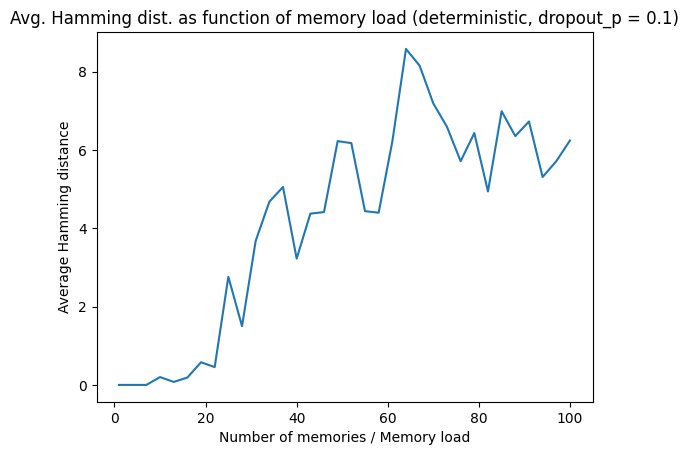

In [154]:
def plot_hamming_distances(dropout_p):
    avg_hamming_distances = []
    memory_loads_to_consider = range(1, 101, 3)

    for M in memory_loads_to_consider:
        memories = [generate_memory() for _ in range(M)]
        model = HopfieldNetwork(memories)
        hamming_distances = []
        for mu in memories:
            # Clamp network activity to the degraded input pattern
            mu_ = degrade_input(mu, dropout_p)
            model.activity = mu_
            dist = model.attempt_recall(mu, mu_)
            hamming_distances.append(dist)
        avg_hamming_distance = np.mean(hamming_distances)
        avg_hamming_distances.append(avg_hamming_distance)

    # Plot the average Hamming distance as a function of the number of memories
    plt.plot(memory_loads_to_consider, avg_hamming_distances)
    plt.xlabel("Number of memories / Memory load")
    plt.ylabel("Average Hamming distance")
    plt.title("Avg. Hamming dist. as function of memory load (deterministic, dropout_p = {})".format(dropout_p))
    plt.show()

plot_hamming_distances(0.1)

The system's recall performance is flawless as long as the memory load does not exceed $15$ memories. For higher loads, recall performance worsens. becoming much less reliable for $30$ or more memories. If the memory load is increased further, say, beyond a total capacity limit of $50$, memory performance -- as measured by Hamming distance -- does not become worse but may, actually, slowly improve again. However, this effect occurs because attractor states are more densely packed in the state space, not because convergence to the correct memory becomes more reliable.

The average recall performance for any given memory load depends on how many entries of the noisy input patterns are masked during recall. Surprisingly, this does not (strongly) hold for the number of memories that can be stored in the network without error, as shown by the below plots:

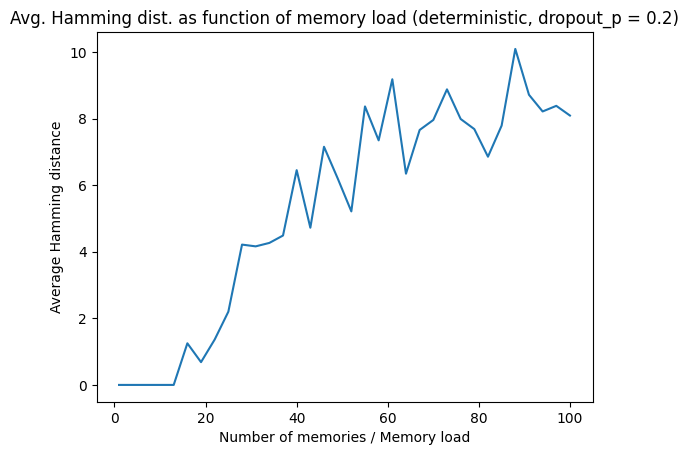

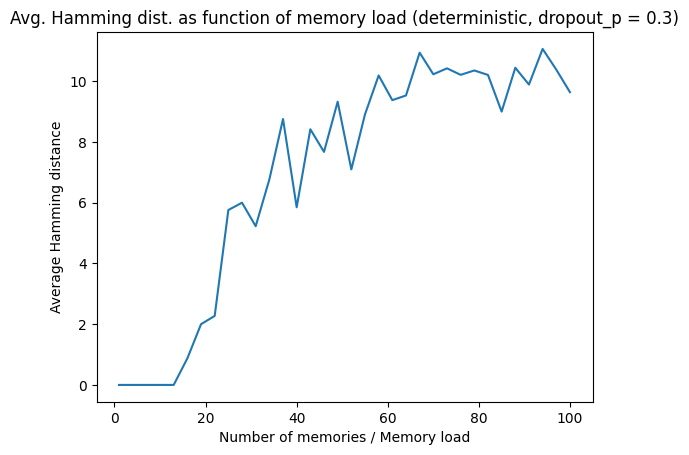

In [59]:
plot_hamming_distances(0.2)
plot_hamming_distances(0.3)

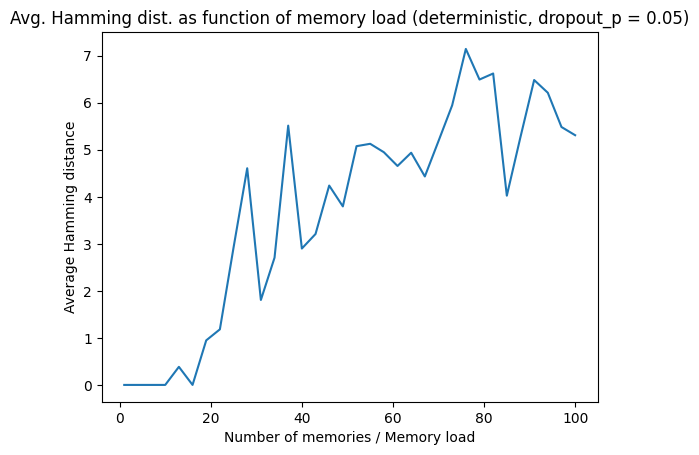

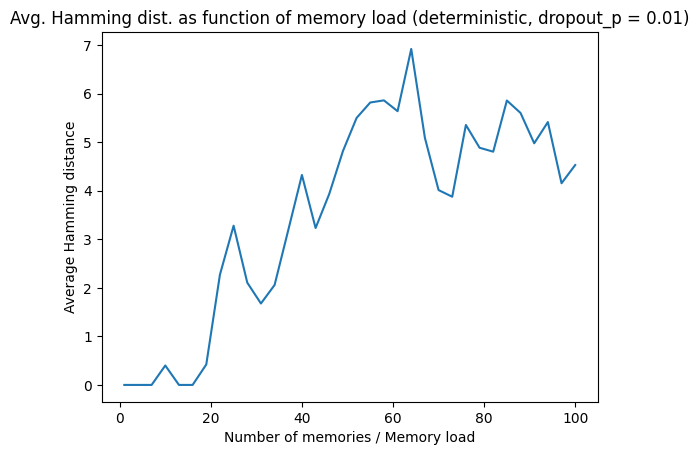

In [60]:
plot_hamming_distances(0.05)
plot_hamming_distances(0.01)

Although we don't explore this in this Lab, it should be noted that the recall performance of associative memory systems also depends on the sparsity of the activity patterns to memorize. Sparse, and hence less overlapping patterns, are generally easier to store. This has been known at least since Marr's theory of the hippocampus as a simple memory system (1971).

#### Part 2: Cortical Pruning and the Development of Schizophrenia

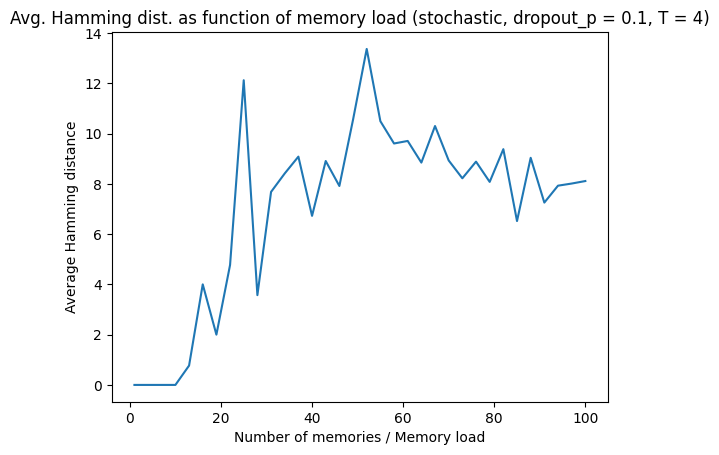

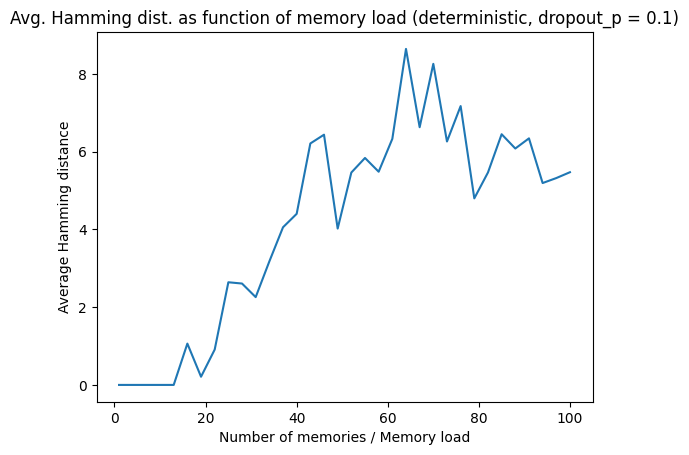

In [155]:
# Make a class that inherits from HopfieldNetwork and overwrites the update_activity method
class StochasticHopfieldNetwork(HopfieldNetwork):
    def __init__(self, memories, height=10, width=10, T=4, rng=None):
        super().__init__(memories, height, width)
        self.T = T
        # Use an existing RNG if provided; otherwise, create a new one. This allows for reproducibility.
        self.rng = rng if rng else np.random.default_rng()

    def update_activity(self):
        E = self.compute_input()
        P = 1 / (1 + np.exp(-E / self.T))
        # Use the RNG to generate random values for reproducibility
        self.activity = [1 if self.rng.random() < p else -1 for p in P]
        self.activity = np.array(self.activity).reshape((self.height, self.width))


    def apply_pruning(self, pruning_coef=0.6):
        for x in range(self.height):
            for y in range(self.width):
                for i in range(self.height):
                    for j in range(self.width):
                        threshold = pruning_coef * np.sqrt((i - x)**2 + (j - y)**2)
                        if np.abs(self.W[x * self.width + y, i * self.width + j]) < threshold:
                            self.W[x * self.width + y, i * self.width + j] = 0

def plot_hamming_distances_stochastic(dropout_p, T):
    avg_hamming_distances = []
    memory_loads_to_consider = range(1, 101, 3)

    for M in memory_loads_to_consider:
        memories = [generate_memory() for _ in range(M)]
        model = StochasticHopfieldNetwork(memories, T=T)
        hamming_distances = []
        for mu in memories:
            # Clamp network activity to the degraded input pattern
            mu_ = degrade_input(mu, dropout_p)
            model.activity = mu_
            dist = model.attempt_recall(mu, mu_)
            hamming_distances.append(dist)
        avg_hamming_distance = np.mean(hamming_distances)
        avg_hamming_distances.append(avg_hamming_distance)

    # Plot the average Hamming distance as a function of the number of memories
    plt.plot(memory_loads_to_consider, avg_hamming_distances)
    plt.xlabel("Number of memories / Memory load")
    plt.ylabel("Average Hamming distance")
    plt.title("Avg. Hamming dist. as function of memory load (stochastic, dropout_p = {}, T = {})".format(dropout_p, T))
    plt.show()

plot_hamming_distances_stochastic(0.1, 4)
plot_hamming_distances(0.1)

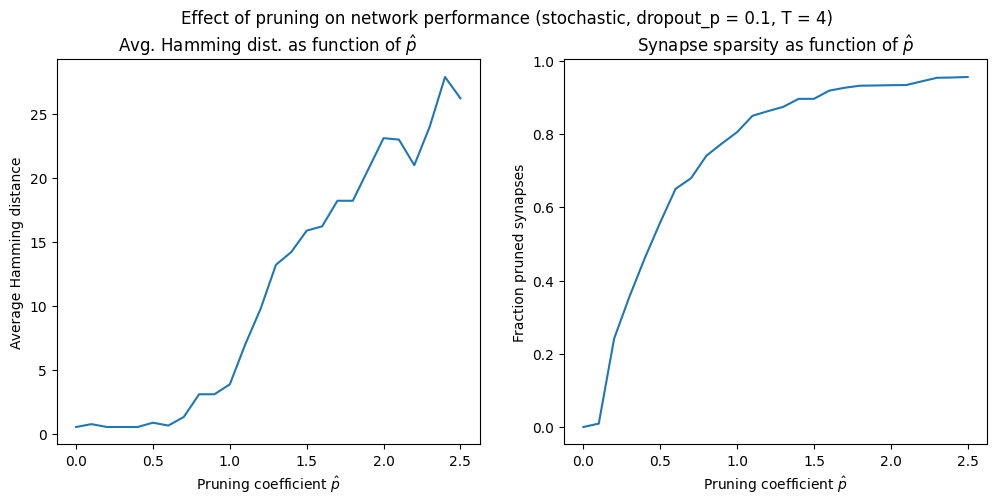

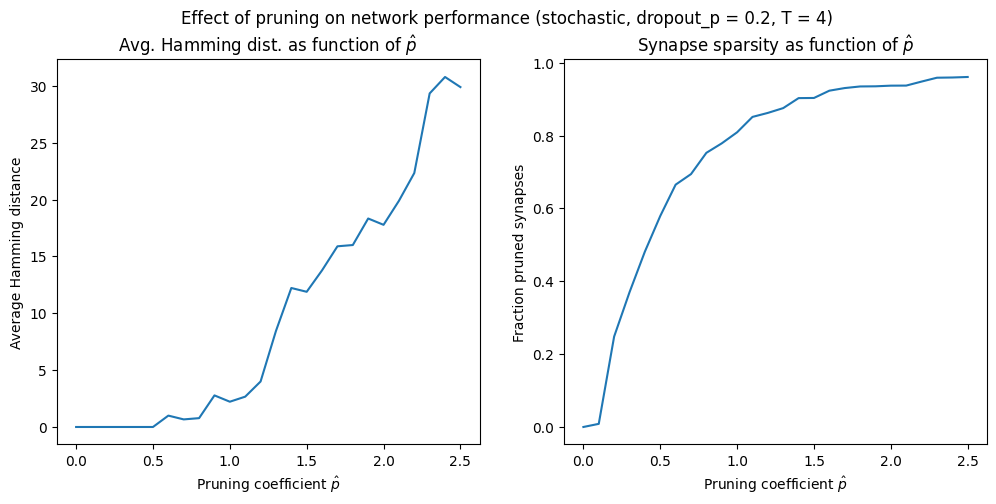

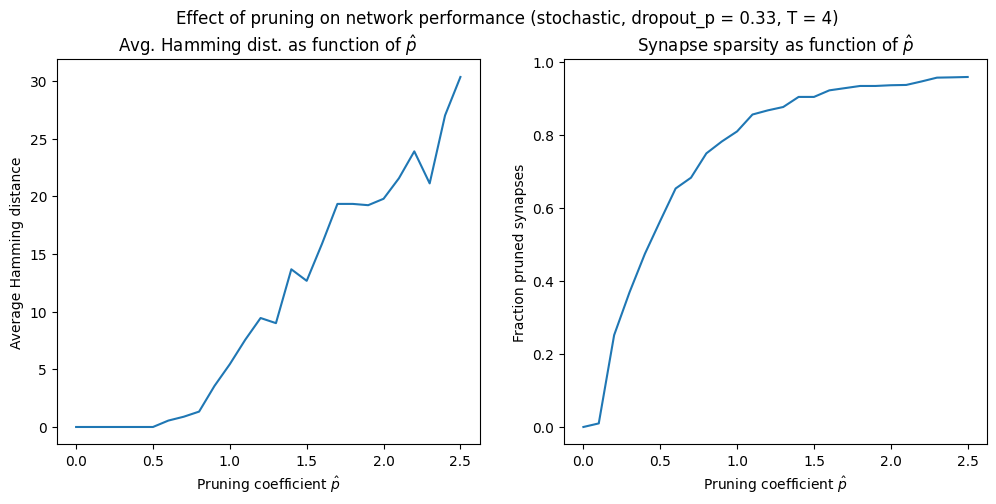

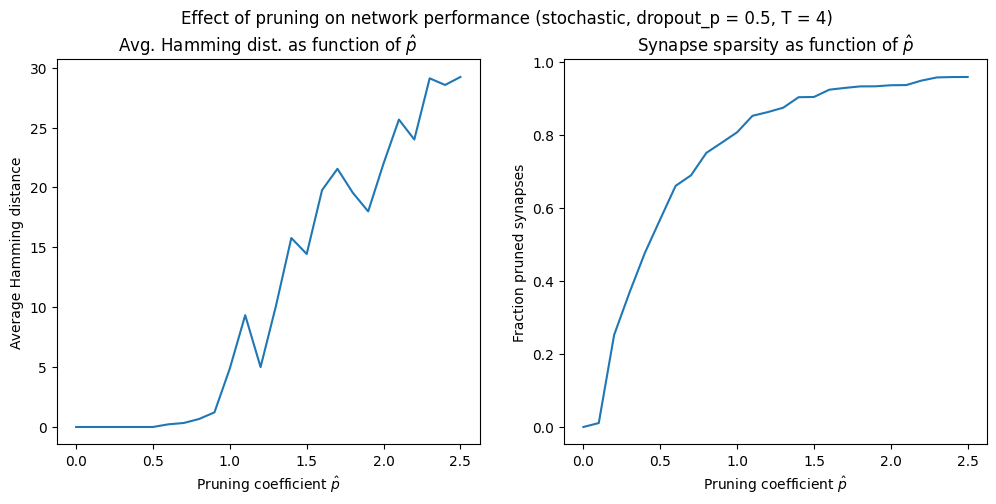

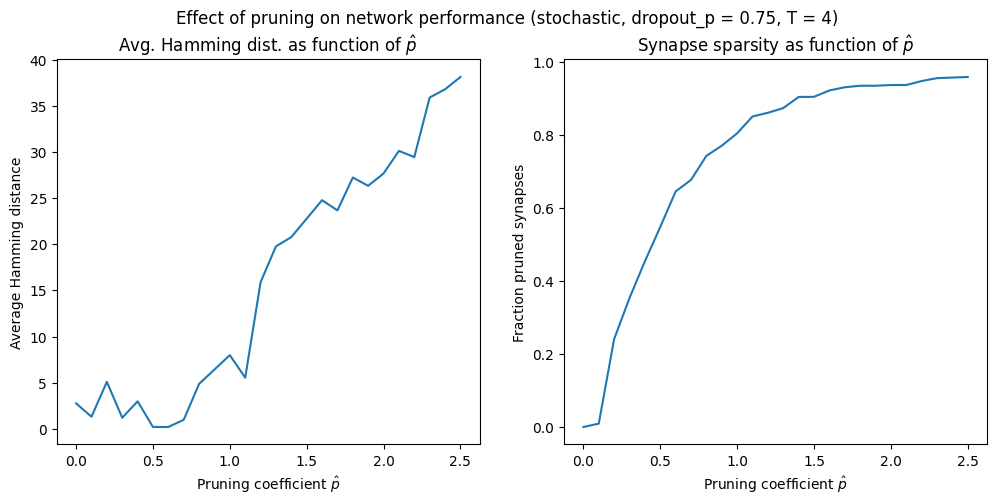

In [150]:
def plot_pruning(dropout_p, T=4):

    memories = [generate_memory() for _ in range(9)]
    model = StochasticHopfieldNetwork(memories, T=4)

    # Gradually increase the pruning coefficient and measure the network's performance
    pruning_coefs = np.linspace(0, 2.5, 26)
    avg_hamming_distances = []
    sparsities = []
    for pruning_coef in pruning_coefs:
        model.apply_pruning(pruning_coef)
        # Print sparsity of model weights
        sparsity = np.sum(model.W == 0) / model.W.size
        sparsities.append(sparsity)
        hamming_distances = []
        for mu in memories:
            # Clamp network activity to the degraded input pattern
            mu_ = degrade_input(mu, dropout_p)
            model.activity = mu_
            dist = model.attempt_recall(mu, mu_)
            hamming_distances.append(dist)
        avg_hamming_distance = np.mean(hamming_distances)
        avg_hamming_distances.append(avg_hamming_distance)

    # Plot the average Hamming distance as a function of the pruning coefficient

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle("Effect of pruning on network performance (stochastic, dropout_p = {}, T = {})".format(dropout_p, T))
    axes[0].plot(pruning_coefs, avg_hamming_distances)
    axes[0].set_xlabel(r"Pruning coefficient $\hat p$")
    axes[0].set_ylabel("Average Hamming distance")
    axes[0].set_title(r"Avg. Hamming dist. as function of $\hat p$")
    axes[1].plot(pruning_coefs, sparsities)
    axes[1].set_xlabel(r"Pruning coefficient $\hat p$")
    axes[1].set_ylabel("Fraction pruned synapses")
    axes[1].set_title(r"Synapse sparsity as function of $\hat p$")
    plt.show()

plot_pruning(0.1)
plot_pruning(0.2)
plot_pruning(0.33)
plot_pruning(0.5)
plot_pruning(0.75)

We would now like to assess the occurrence of "functional fragmentation" or "spurious attractors" after pruning.

We can define a network that stores a number of pre-defined memories. We will then apply heavy pruning to the network, assess the recall of one of the memories and observe the network's behaviour during (attempted) convergence.

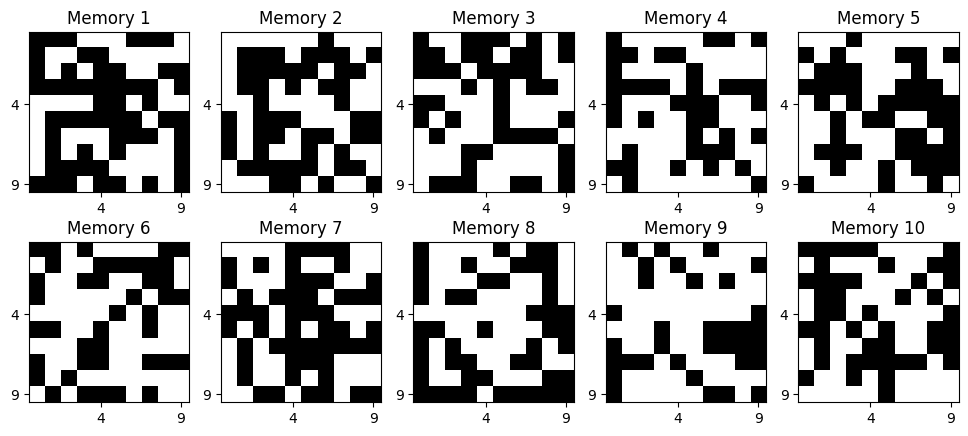

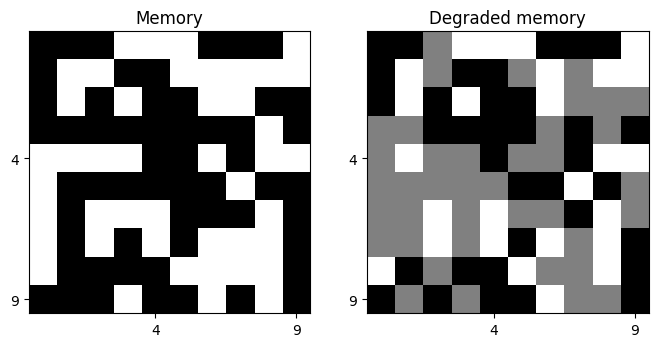

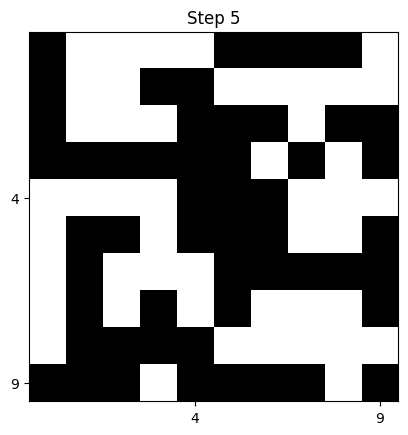

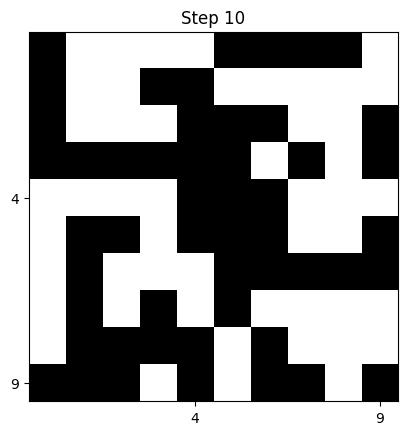

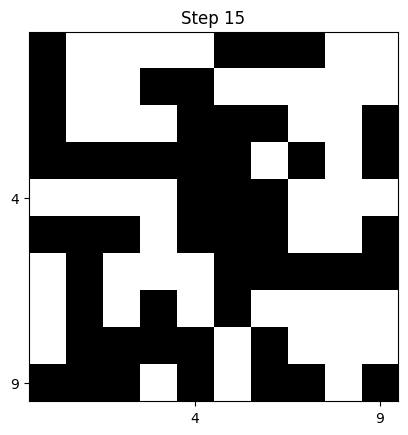

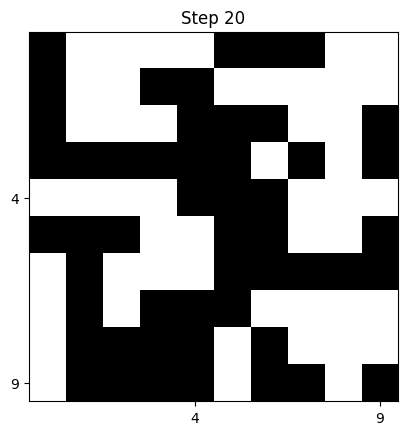

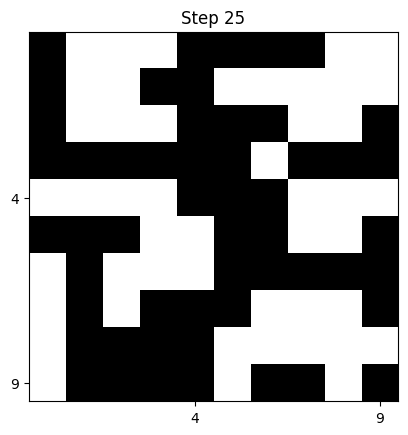

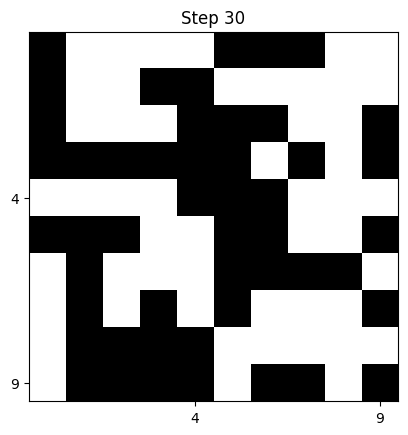

Hamming distance to memory 1: 21
Hamming distance to memory 2: 53
Hamming distance to memory 3: 32
Hamming distance to memory 4: 30
Hamming distance to memory 5: 63
Hamming distance to memory 6: 58
Hamming distance to memory 7: 30
Hamming distance to memory 8: 49
Hamming distance to memory 9: 57
Hamming distance to memory 10: 59


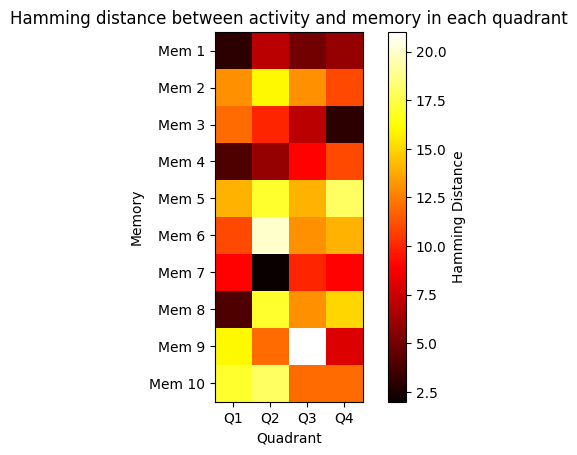

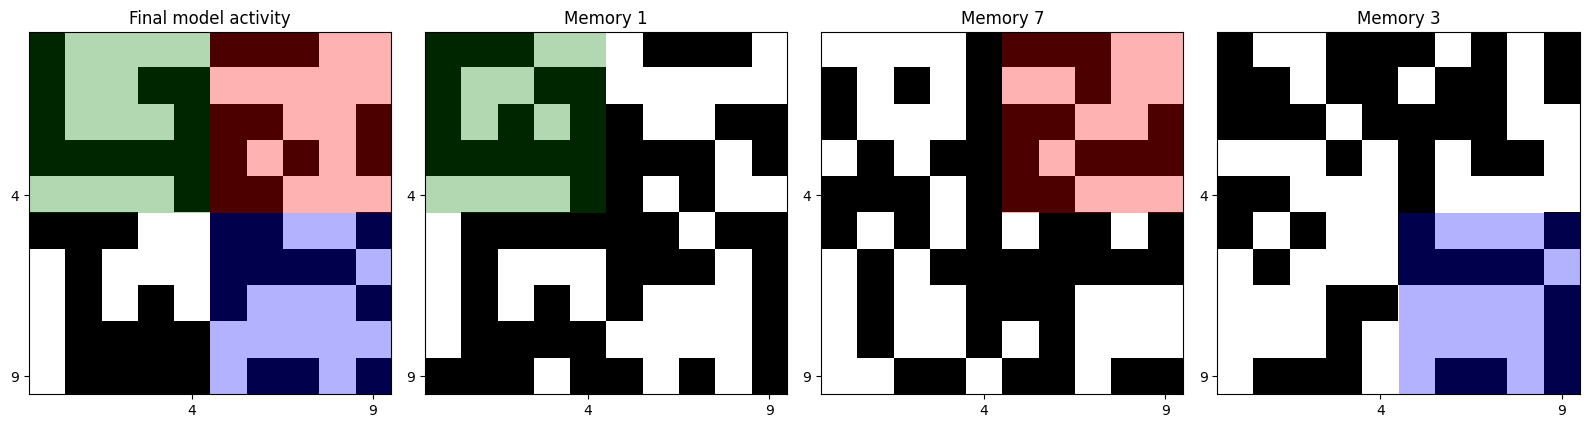

In [223]:
# Create a single random generator with a fixed seed
rng = np.random.default_rng(seed=30)

# Generate memories with the seeded RNG
memories = [generate_memory(rng=rng) for _ in range(10)]

# Plot the structured memories
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, mu in enumerate(memories):
    axes[i // 5, i % 5].imshow(mu.reshape((10, 10)), cmap='gray')
    axes[i // 5, i % 5].set_title(f"Memory {i + 1}")
    axes[i // 5, i % 5].set_xticks([4, 9])
    axes[i // 5, i % 5].set_yticks([4, 9])
plt.show()

# Create the Hopfield model
model = StochasticHopfieldNetwork(memories, T=4, rng=rng)
model.apply_pruning(1.25)

# Degrade memory with the same RNG
mu = memories[0]
mu_ = degrade_input(mu, dropout_p=0.35, rng=rng)

# Plot mu and mu_
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(mu.reshape((10, 10)), cmap='gray')
axes[0].set_title("Memory")
axes[0].set_xticks([4, 9])
axes[0].set_yticks([4, 9])
axes[1].imshow(mu_.reshape((10, 10)), cmap='gray')
axes[1].set_title("Degraded memory")
axes[1].set_xticks([4, 9])
axes[1].set_yticks([4, 9])
plt.show()

# Update the model activity and plot it
model.activity = mu_
for step in range(30):
    model.update_activity()  # Ensure `model.update_activity` uses the same RNG
    if step % 5 == 4:
        plt.imshow(model.activity, cmap='gray')
        plt.title(f"Step {step + 1}")
        plt.xticks([4, 9])
        plt.yticks([4, 9])
        plt.show()

# Print the Hamming distance
for i, mu in enumerate(memories):
    dist = np.sum(model.activity.flatten() != mu)
    print(f"Hamming distance to memory {i + 1}: {dist}")

# NOTE. For exploration purposes, we plot the distance between the converged activity and each memory within each quadrant.
heatmap = np.zeros((10, 4))
# Loop through each memory and compute distances
for i, mu in enumerate(memories):
    mu_reshaped = mu.reshape((10, 10))  # Reshape memory for quadrant comparisons
    for x in range(10):
        for y in range(10):
            # Determine which quadrant the (x, y) point belongs to
            if x < 5 and y < 5:  # Top-left (1st quadrant)
                heatmap[i, 0] += model.activity[x, y] != mu_reshaped[x, y]
            elif x < 5 and y >= 5:  # Top-right (2nd quadrant)
                heatmap[i, 1] += model.activity[x, y] != mu_reshaped[x, y]
            elif x >= 5 and y < 5:  # Bottom-left (3rd quadrant)
                heatmap[i, 2] += model.activity[x, y] != mu_reshaped[x, y]
            elif x >= 5 and y >= 5:  # Bottom-right (4th quadrant)
                heatmap[i, 3] += model.activity[x, y] != mu_reshaped[x, y]

# Plot the heatmap
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.xlabel("Quadrant")
plt.ylabel("Memory")
plt.title("Hamming distance between activity and memory in each quadrant")
plt.colorbar(label="Hamming Distance")
plt.xticks(range(4), ["Q1", "Q2", "Q3", "Q4"])  # Quadrant labels
plt.yticks(range(10), [f"Mem {i+1}" for i in range(10)])  # Memory labels
plt.show()


fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# First subplot: Final model activity with shaded quadrants
axes[0].imshow(model.activity, cmap='gray')
axes[0].set_title("Final model activity")
axes[0].set_xticks([4, 9])
axes[0].set_yticks([4, 9])

# Shade Quadrant 1 (top-left) in green
axes[0].axhspan(-0.5, 4.5, xmin=0, xmax=0.5, facecolor='green', alpha=0.3)
# Shade Quadrant 2 (top-right) in red
axes[0].axhspan(-0.5, 4.5, xmin=0.5, xmax=1, facecolor='red', alpha=0.3)
# Shade Quadrant 4 (bottom-right) in blue
axes[0].axhspan(4.5, 9.5, xmin=0.5, xmax=1, facecolor='blue', alpha=0.3)

# Second subplot: Memory 1
axes[1].imshow(memories[0].reshape((10, 10)), cmap='gray')
axes[1].set_title("Memory 1")
axes[1].set_xticks([4, 9])
axes[1].set_yticks([4, 9])
# Shade quadrants 1 in green
axes[1].axhspan(-0.5, 4.5, xmin=0, xmax=0.5, facecolor='green', alpha=0.3)

# Third subplot: Memory 7
axes[2].imshow(memories[6].reshape((10, 10)), cmap='gray')
axes[2].set_title("Memory 7")
axes[2].set_xticks([4, 9])
axes[2].set_yticks([4, 9])
# Shade quadrant 2 in red
axes[2].axhspan(-0.5, 4.5, xmin=0.5, xmax=1, facecolor='red', alpha=0.3)

# Fourth subplot: Memory 3
axes[3].imshow(memories[2].reshape((10, 10)), cmap='gray')
axes[3].set_title("Memory 3")
axes[3].set_xticks([4, 9])
axes[3].set_yticks([4, 9])
# Shade quadrant 4 in blue
axes[3].axhspan(4.5, 9.5, xmin=0.5, xmax=1, facecolor='blue', alpha=0.3)

plt.tight_layout()
plt.show()


In the above example, the final activity pattern of the model resembles the correct memory (1) most closely in the top-left quadrant, but is actually more similar to memories 7 / 3 in quadrants 2 / 4. The model thus ends up in a mixture of memories at once. Synaptic pruning appears to cause a loss of coherence among the network activities in different regions of the topological space. At least intuitively (and, perhaps, naively?), this phenomenon could be said to resemble the dyscoordination of thoughts, actions and emotions (processed, to some degree, in separate parts of the brain) that is said to occur in Schizophrenia [https://academic.oup.com/schizophreniabulletin/article/34/1/155/1892304].

On another note, the notable "T-shape" in the lower left quadrant of the network activity first occurs on Step 15 of convergence, and then persists, although it does not appear in any of the network's stored patterns. This is what Hoffmann and Dobscha call a "parasitic locus". One might liken this phenomenon to the occurrence of persistent thoughts in Schizophrenia, that appear to be improperly grounded in previous experience. The author of this solution finds that argument a bit less convincing -- but you be the judge!